In [1]:
import numpy as np
import apogee.tools.read as apread
from matplotlib import pyplot as plt
import pandas as pd
import csv
from apogee.tools import bitmask
import math
from astropy.io import fits
import os.path
from pathlib import Path

In [2]:
#Calculate R-Values for given ranges
def calcR(x,pm):
    ccfCenter = max(x)
    primary = np.where(x == ccfCenter)
    peak_loc = primary[0][0]
    if peak_loc < pm: 
        pm = peak_loc
    if peak_loc > 401 - pm:
        pm = 401 - peak_loc
    if peak_loc == 0:
        r = 1000
        return r 
    endpoint = peak_loc+pm
    startpoint= peak_loc-pm
    Mirror = (x[peak_loc:endpoint])[::-1]
    sigmaA = np.sqrt(1.0 / (2.0 * len(Mirror)) * np.sum((x[startpoint:peak_loc] - Mirror)**2))
    r = np.max(x) / (np.sqrt(2.0) * sigmaA)
    return r

In [3]:
#Calculate the bisector points for a CCF (uses 4 points)
def bisector(xccf,yccf):
    height = max(yccf) - min(yccf)
    slices = height/4.0
    bounds = np.arange(min(yccf),height,slices)
    if len(bounds) != 0:
        z1 = (bounds[0] + bounds[1])/2.0
        z2 = (bounds[1] + bounds[2])/2.0
        z3 = (bounds[2] + bounds[3])/2.0
        z4 = (bounds[3] + bounds[4])/2.0
        y_bisector = np.array([z1,z2,z3,z4])

        x_bisector = []
        x0 = []
        x1 = []
        x2 = []
        x3 = []
        for i in range(len(yccf)):
            if yccf[i] <= bounds[4] and yccf[i] > bounds[3]:
                x0.append(xccf[i])
        x_0 = (np.mean(x0))
        x_bisector.append(x_0)

        i = 0
        for i in range(len(yccf)):
            if yccf[i] <= bounds[3] and yccf[i] >= bounds[2]:
                x1.append(xccf[i])
        x_1=(np.mean(x1))
        x_bisector.append(x_1)

        i = 0
        for i in range(len(yccf)):
            if yccf[i] <= bounds[2] and yccf[i] >= bounds[1]:
                x2.append(xccf[i])
        x_2=(np.mean(x2))
        x_bisector.append(x_2)

        i = 0
        for i in range(len(yccf)):
            if yccf[i] <= bounds[1] and yccf[i] >= bounds[0]:
                x3.append(xccf[i])
        x_3=(np.mean(x3))
        x_bisector.append(x_3)

        bisector_pts = np.vstack([x_bisector,y_bisector])
        #print(bisector_pts)
        return(bisector_pts)

def xrange(x_bisector):
    #print(x_bisector)
    xr = max(x_bisector) - min(x_bisector)
    return xr

In [4]:
#Find the R ratios of the SB2s
binR1 = []
binR2 = []
def r_ratio(r51,r151,r101):
        #print(r51, r101,r151)
        r1_ratio = r151/r101
        r2_ratio = r101/r51
        R1_ratio = math.log10(r1_ratio)
        R2_ratio = math.log10(r2_ratio)
        ratios = [round(R1_ratio,3),round(R2_ratio,3)]
        return ratios
'''for i in range(len(binApoID)):
    Ratios = r_ratio(R51s[i],R151s[i],R101s[i])
    r1 = Ratios[0]
    r2 = Ratios[1]
    binR1.append(r1)
    binR2.append(r2)''';

In [5]:
def idSB2s(R1_ratio, R2_ratio,r51,r151,r101,xr): # cuts to identify SB2s from Kevin's IDL Routine
    min_r51 = r51
    min_r101 = r101
    min_r151 = r151
    r1_ratio = R1_ratio
    r2_ratio = R2_ratio
    max_xr = xr
    
    likely_sb2s = np.where((math.log10(r1_ratio) > 0.06 and (math.log10(r1_ratio) < 0.13 and 
                            math.log10(min_r101) < 0.83)) or (math.log10(r2_ratio) > 0.05 and 
                            math.log10(r2_ratio) < 0.02 and math.log10(min_r51) < 0.83) and
                            math.log10(min_r51) > 0.25 and math.log10(min_r101) > 0.22 and
                            math.log10(peak_401) > -0.5 and math.log10(max_xr) < 2.3 and 
                            math.log10(max_xr) > 0.7
                          )
    return likely_sb2s

In [6]:
def arrays(x):
    x = np.array(x)
    new = x.astype(np.float)
    return new

In [87]:
def logs(x):
    new = []
    for i in range(len(x)):
        element = math.log10(x[i])
        #print(element)
        new.append(element)
    new = np.array(new)
    out = new.astype(np.float)
    return out

In [61]:
# Read in visually id SB2s and generate catalog for binaries
bins = pd.read_csv('KC_Binaries.csv',delimiter='\t')
locID = bins['Location_ID']
apoID = bins['Apogee_ID']
ids = bins['ID']
with open('KC_Binary_Stats.csv','w') as output:
    column = ['LocationID','ApogeeID','Visit','SNR','xRng','R51','R101','R151','R151/101','R101/51']
    writer = csv.DictWriter(output,delimiter='\t',fieldnames=column)
    writer.writeheader()
    
    binApoID = []
    binLocID = []
    R151s = []
    R101s = []
    R51s = []
    bin_xr = []
    for i in range(len(ids)):
        if ids[i] != 0:
            binApoID.append(apoID[i])
            binLocID.append(locID[i])
    print(len(binApoID))
    bin_SNR = []
    for j in range(len(binLocID)):
        locationID = binLocID[j]
        apogeeID = binApoID[j]
        my_file = Path('/Volumes/coveydata/APOGEE_Spectra/APOGEE2_DR14/dr14/apogee/spectro/redux/r8/stars/apo25m/'+str(locationID)+'/'+'apStar-r8-'+str(apogeeID)+'.fits')
        try: 
            path = '/Volumes/coveydata/APOGEE_Spectra/APOGEE2_DR14/dr14/apogee/spectro/redux/r8/stars/apo25m/'+str(locationID)+'/'+'apStar-r8-'+str(apogeeID)+'.fits'
            data = fits.open(path)
            point = data[9]
            xccf = point.data[0][32]
            CCF = point.data[0][27]
            HDU0 = fits.getheader(path,0)
            nvisits = HDU0['NVISITS']
            if nvisits != 1:
                for visit in range(0,nvisits):
                    ccf = CCF[visit+2]
                    snr = HDU0['SNRVIS'+str(visit+1)]
                    nonzeroes = np.count_nonzero(ccf) # This condition is meant to eliminate visits that are empty
                    if nonzeroes >= 1:
                        bs_pt = bisector(xccf, ccf)
                        x_range = xrange(bs_pt[0])
                        bin_xr.append(x_range)
                        bin_SNR.append(snr) 
                        R151 = calcR(ccf,75)
                        R101 = calcR(ccf,50)
                        R51 = calcR(ccf,25)
                        R151s.append(R151)
                        R101s.append(R101)
                        R51s.append(R51)
                        Ratios = r_ratio(R51,R151,R101)
                        r1 = Ratios[0]
                        r2 = Ratios[1]
                        writer.writerow({'LocationID':locationID,'ApogeeID':apogeeID,'Visit':visit,'SNR':snr,'xRng':round(x_range,3),
                                                     'R51':round(R51,3),'R101':round(R101,3),'R151':round(R151,3),'R151/101':r1,'R101/51':r2})
                    else:
                        pass

        except FileNotFoundError:
            #print('enter')
            pass

1071


In [13]:
#Read in binary stats
bindata = pd.read_csv('KC_Binary_Stats.csv',delimiter='\t')
bin_locationID = bindata['LocationID']
bin_apogeeID = bindata['ApogeeID']
binr51 = bindata['R51']
binr101 = bindata['R101']
binr151 = bindata['R151']
binR1 = bindata['R151/101']
binR2 = bindata['R101/51']
bin_xrange = bindata['xRng']
bin_visit = bindata['Visit']
print(len(bin_visit))

4590


In [10]:
dr14data = pd.read_csv('DR14_Stat_Catalog_Complete.csv',delimiter='\t')
all_r51 = dr14data['R51']
all_r101 = dr14data['R101']
all_r151 = dr14data['R151']
all_ratio1 = dr14data['R151/101']
all_ratio2 = dr14data['R101/51']
all_snr = dr14data['SNR']
all_xr = dr14data['xRng']
locationID = dr14data['Location_ID']
apogeeID = dr14data['Apogee_ID']
all_visit = dr14data['Visit']
print(len(apogeeID))

943028


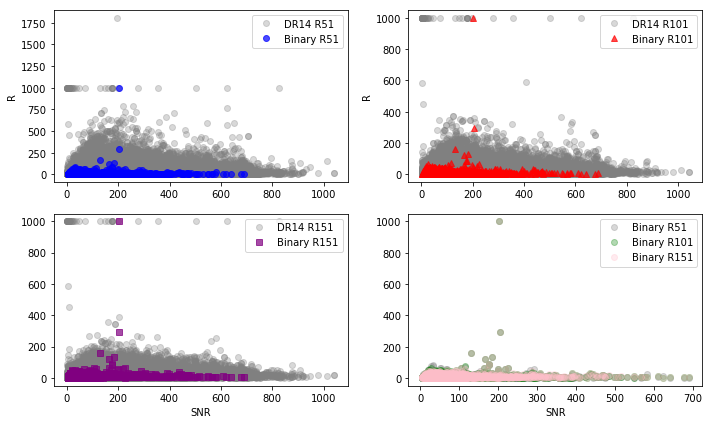

In [32]:
# Make graphs of all of DR14 snr vs R 151 values. Be sure to overplot the previously found binary values as well. 
fig = plt.figure(figsize=(10,6))

sub1 = plt.subplot(2,2,1)
sub1.plot(all_snr,all_r51, 'o', label='DR14 R51',alpha=0.3,color='grey')
sub1.plot(bin_SNR,R51s,'o', label = 'Binary R51',alpha=0.7,color='blue')
sub1.set_ylabel('R')
sub1.legend(loc='upper right')

sub2= plt.subplot(2,2,2)
sub2.plot(all_snr,all_r101, 'o', label='DR14 R101',alpha=0.3,color='grey')
sub2.plot(bin_SNR,R101s,'^',label='Binary R101',alpha=0.7,color='red')
sub2.set_ylabel('R')
sub2.legend(loc='upper right')

sub3 = plt.subplot(2,2,3)
sub3.set_xlabel('SNR')
sub3.plot(all_snr,all_r151, 'o', label='DR14 R151',alpha=0.3,color='grey')
sub3.plot(bin_SNR,R151s, 's',label='Binary R151',alpha=0.7,color='purple')
sub3.legend(loc='upper right')

sub4 = plt.subplot(2,2,4)
sub4.set_xlabel('SNR')
sub4.plot(bin_SNR,R51s, 'o', label='Binary R51',alpha=0.3,color='grey')
sub4.plot(bin_SNR,R101s,'o',label='Binary R101',alpha=0.3,color='green')
sub4.plot(bin_SNR,R151s,'o',label='Binary R151',alpha=0.3,color='pink')
sub4.legend(loc='upper right')

fig.tight_layout()
plt.savefig('All R vs SNR.pdf',dpi=400)
plt.show()

In [78]:
# All of DR14 minimum R and R ratios as well as max x-ranges
R51 = []
R101 = []
R151 = []
ratio1 = []
ratio2 = []
xRanges = []

for i in range(len(apogeeID)):
    R51s = []
    R101s = []
    R151s = []
    r1s = []
    r2s = []
    xrs = []
    if all_visit[i]!=0:
        R51s.append(all_r51[i])
        R51.append(min(R51s))
        R101s.append(all_r101[i])
        R101.append(min(R101s))
        R151s.append(all_r151[i])
        R151.append(min(R151s))
        r1s.append(all_ratio1[i])
        ratio1.append(min(r1s))
        r2s.append(all_ratio2[i])
        ratio2.append(min(r2s))
        xrs.append(all_xr[i])
        xRanges.append(max(xrs))

In [79]:
# Find R and R ratio minimums and max x-ranges for binaries
# All of DR14 minimum R and R ratios as well as max x-ranges
binR51 = []
binR101 = []
binR151 = []
binratio1 = []
binratio2 = []
binxRanges = []

for i in range(len(bin_apogeeID)):
    R51s = []
    R101s = []
    R151s = []
    r1s = []
    r2s = []
    xrs = []
    if bin_visit[i]!=0:
        R51s.append(binr51[i])
        binR51.append(min(R51s))
        R101s.append(binr101[i])
        binR101.append(min(R101s))
        R151s.append(binr151[i])
        binR151.append(min(R151s))
        r1s.append(binR1[i])
        binratio1.append(min(r1s))
        r2s.append(binR2[i])
        binratio2.append(min(r2s))
        xrs.append(bin_xrange[i])
        binxRanges.append(max(xrs))

In [85]:
R_51 = arrays(R51)
R_101 = arrays(R101)
R_151 = arrays(R151)
Ratio1 = arrays(ratio1)
Ratio2 = arrays(ratio2)
x_range = arrays(xRanges)
#Binary arrays 
binR51 = arrays(binR51)
binR101 = arrays(binR101)
binR151 = arrays(binR151)
BinR1 = arrays(binratio1)
BinR2 = arrays(binratio2)
binxrange = arrays(binxRanges)

In [88]:
R_51 = logs(R51)
R_101 = logs(R101)
R_151 = logs(R151)
x_range = logs(xRanges)
#Binary arrays 
binR51 = logs(binR51)
binR101 = logs(binR101)
binR151 = logs(binR151)
binxrange = logs(binxRanges)

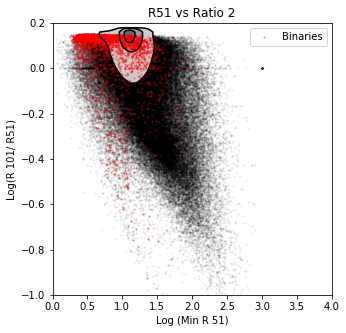

In [95]:
'''
Task: Find what R relations will provide the highest percentage of SB2s. 
Reminder: The binaries being used are from the IDL Routine 
Construct contour plots for the following relations:
1) Min R51 vs Min R101/51 (Min Ratio 2)
2) Min R101 vs Min R151/101 (Min Ratio 1)
3) Min R151 vs Min 51
4) Max x-range vs Ratio 1
5) Max x-range vs Ratio 2
'''
import corner

#All of DR14 for #1
plt.figure(figsize=(5,5))
corner.hist2d(R_51,Ratio2,bins=80,plot_contours=True,fill_contours=True,smooth=1.2,plot_datapoints=True)
plt.scatter(binR51,BinR2,s=1.5,alpha=0.30,color='red',label='Binaries')
plt.legend(loc='upper right')
plt.xlabel('Log (Min R 51)')
plt.ylabel('Log(R 101/ R51)')
plt.title('R51 vs Ratio 2')
plt.xlim(0,4)
plt.ylim(-1.0,0.2)
plt.savefig('R51vsRatio2.pdf',dpi=900)
plt.show()

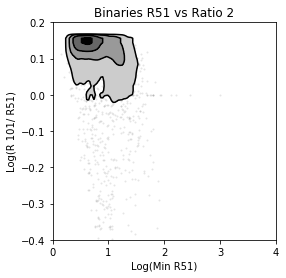

In [100]:
# Make plot for #1 with Binaries
plt.figure(figsize=(4,4))
corner.hist2d(binR51,BinR2,bins=90,plot_contours=True,fill_contours=True,smooth=1.2,plot_datapoints=True)
plt.xlabel('Log(Min R51)')
plt.ylabel('Log(R 101/ R51)')
plt.title('Binaries R51 vs Ratio 2')
plt.xlim(0,4)
plt.ylim(-0.4,0.2)
plt.savefig('BinaryonlyR51vsRatio2.pdf',dpi=900)
plt.show()

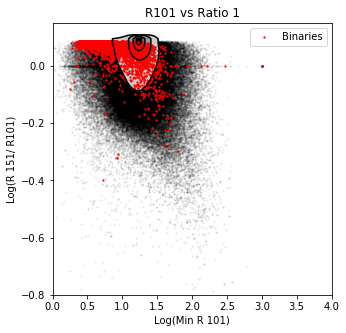

In [104]:
# Make plot for #2 for DR14 then for Binaries

plt.figure(figsize=(5,5))
corner.hist2d(R_101,Ratio1,bins=80,plot_contours=True,fill_contours=True,smooth=1.2,plot_datapoints=True)
plt.scatter(binR101,BinR1,s=1.5,color='red',label='Binaries')
plt.xlabel('Log(Min R 101)')
plt.ylabel('Log(R 151/ R101)')
plt.title('R101 vs Ratio 1')
plt.legend(loc='upper right')
plt.xlim(0,4)
plt.ylim(-0.8,0.15)
plt.savefig('R101vsRatio1.pdf',dpi=900)
plt.show()

'''#Binary
plt.figure(figsize=(4,4))
corner.hist2d(binR101,BinR1,bins=80,plot_contours=True,fill_contours=True,smooth=1.2,plot_datapoints=True)
plt.xlabel('Min R 101')
plt.ylabel('Log(R 151/ R101)')
plt.title('Binary R101 vs Ratio 1')
plt.xlim(0,100)
plt.ylim(-0.3,0.12)
plt.show()''';

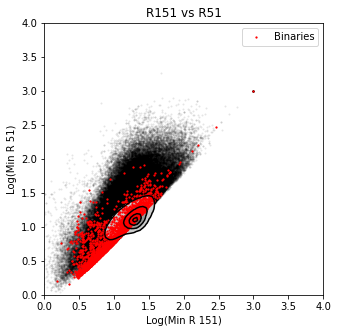

In [110]:
# Make a plot for #3 for DR14 and Binaries
plt.figure(figsize=(5,5))
corner.hist2d(R_151,R_51,bins=80,plot_contours=True,fill_contours=True,smooth=1.2,plot_datapoints=True)
plt.scatter(binR151,binR51,s=1.5,color='red',label='Binaries')
plt.xlabel('Log(Min R 151)')
plt.ylabel('Log(Min R 51)')
plt.title('R151 vs R51')
plt.legend(loc='upper right')
plt.xlim(0,4)
plt.ylim(0,4)
plt.savefig('R151vsR51.pdf',dpi=900)
plt.show()

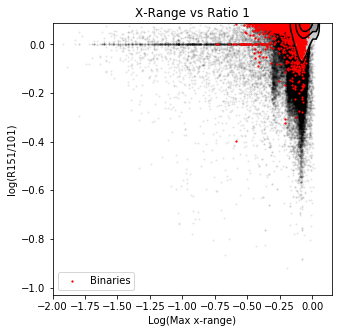

In [106]:
# Make a plot for #4
plt.figure(figsize=(5,5))
corner.hist2d(x_range,Ratio1,bins=80,plot_contours=True,fill_contours=True,smooth=1.2,plot_datapoints=True)
plt.scatter(binxrange,BinR1,s=1.5,color='red',label='Binaries')
plt.xlabel('Log(Max x-range)')
plt.ylabel('log(R151/101)')
plt.title('X-Range vs Ratio 1')
plt.legend(loc='lower left')
plt.xlim(-2.00,0.15)
#plt.ylim(0,850)
plt.savefig('MaxrangevsRatio1.pdf',dpi=900)
plt.show()


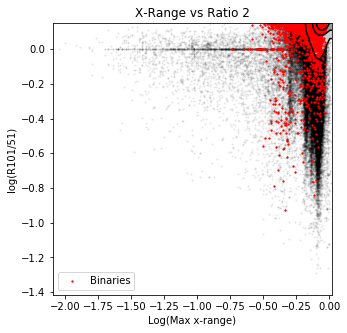

In [107]:
# Make a plot for # 5
plt.figure(figsize=(5,5))
corner.hist2d(x_range,Ratio2,bins=80,plot_contours=True,fill_contours=True,smooth=1.2,plot_datapoints=True)
plt.scatter(binxrange,BinR2,s=1.5,color='red',label='Binaries')
plt.xlabel('Log(Max x-range)')
plt.ylabel('log(R101/51)')
plt.title('X-Range vs Ratio 2')
plt.legend(loc='lower left')
#plt.xlim(0,500)
#plt.ylim(0,850)
plt.savefig('XRangevsRatio2.pdf',dpi=900)
plt.show()

In [ ]:
'''
Determine the cut-offs for binaries by #1,#2 and #3. Check bisector function, those x-ranges are far too small
for binaries. 
Construct a new idSB2s function with new cut-offs.
'''

